In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import pyspark as spark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col
from sklearn.metrics import roc_curve

In [21]:
#Spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

In [8]:
spark = SparkSession.builder \
    .appName("RandomForestSpark") \
    .getOrCreate()

train_df = spark.read.csv('data/application_train.csv',header=True, inferSchema=True)
test_df  = spark.read.csv('data/application_train.csv',  header=True, inferSchema=True)

In [9]:
#Sanity check to ensure spark reads
train_df.show(5)
train_df.printSchema()


+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-------------------+------------------+-------------------+--------------+----------------+---------------------------+------------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------

In [10]:
from pyspark.sql.functions import col as spark_col, when as spark_when

# Add DAYS_EMPLOYED_ANOM flag
train_df = train_df.withColumn(
    "DAYS_EMPLOYED_ANOM",
    (spark_col("DAYS_EMPLOYED") == 365243).cast("int")
)

test_df = test_df.withColumn(
    "DAYS_EMPLOYED_ANOM",
    (spark_col("DAYS_EMPLOYED") == 365243).cast("int")
)

# Replace 365243 with null
train_df = train_df.withColumn(
    "DAYS_EMPLOYED",
    spark_when(
        spark_col("DAYS_EMPLOYED") == 365243,
        None
    ).otherwise(spark_col("DAYS_EMPLOYED"))
)

test_df = test_df.withColumn(
    "DAYS_EMPLOYED",
    spark_when(
        spark_col("DAYS_EMPLOYED") == 365243,
        None
    ).otherwise(spark_col("DAYS_EMPLOYED"))
)


In [11]:
cols_to_drop = [
    "SK_ID_CURR", "OWN_CAR_AGE", "DAYS_EMPLOYED",
    "WEEKDAY_APPR_PROCESS_START", "HOUR_APPR_PROCESS_START",
    "WALLSMATERIAL_MODE", "N"
]

drop_train = [c for c in cols_to_drop if c in train_df.columns]
drop_test  = [c for c in cols_to_drop if c in test_df.columns]

train_df = train_df.drop(*drop_train)
test_df  = test_df.drop(*drop_test)

print("After dropping:")
print("Train cols:", len(train_df.columns))
print("Test  cols:", len(test_df.columns))


After dropping:
Train cols: 117
Test  cols: 117


In [31]:
# 4. Split target
y = train_df["TARGET"]
train_X = train_df.drop(columns=["TARGET"])

# 5. Align train and test *before* encoding
train_X, test_X = train_X.align(test_df, join='inner', axis=1)

print("Training shape:", train_X.shape)
print("Testing shape:", test_X.shape)

# 6. Identify categorical columns (only those that exist)
one_hot_cols = [
    'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
    'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
    'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
    'EMERGENCYSTATE_MODE'
]

# Keep only existing cols after align
one_hot_cols = [c for c in one_hot_cols if c in train_X.columns]

# Split by cardinality
binary_cats = []
multi_cats  = []

for col in one_hot_cols:
    unique_vals = train_X[col].dropna().unique()
    if len(unique_vals) <= 2:
        binary_cats.append(col)
    else:
        multi_cats.append(col)

print("Binary categorical columns:", binary_cats)
print("Multi-class categorical columns:", multi_cats)

# 7. Build ColumnTransformer
ct = ColumnTransformer(
    transformers=[
        ("binary", OrdinalEncoder(), binary_cats),
        ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False), multi_cats),
    ],
    remainder="passthrough"
)

# 8. Fit on train_X, transform both train_X and test_X
X_enc = ct.fit_transform(train_X)
X_test_enc = ct.transform(test_X)

# 9. Extract final feature names
feature_names = ct.get_feature_names_out()
print("Final encoded training shape:", X_enc.shape)
print("Final encoded testing shape:", X_test_enc.shape)

TypeError: DataFrame.drop() got an unexpected keyword argument 'columns'

In [12]:
label_col = "TARGET"

# All feature columns in train (except label)
feature_cols_train = [c for c in train_df.columns if c != label_col]
feature_cols_test  = test_df.columns

# Common feature set (equivalent to train_X, test_X = align(..., join="inner"))
common_features = sorted(list(set(feature_cols_train).intersection(set(feature_cols_test))))

print("Number of common features:", len(common_features))

# Re-select aligned columns
train_df = train_df.select([label_col] + common_features)
test_df  = test_df.select(common_features)

train_df.show(3)


Number of common features: 116
+------+-----------+----------+---------------+----------------+-------------------------+--------------------------+-------------------------+-------------------------+--------------------------+--------------------------+--------------+---------------+---------------+----------------+-----------------+-----------------+------------+---------------+-----------+--------------+---------------+---------------+----------+------------------+---------------+----------------------+-----------------+------------------------+------------------------+-------------+--------------+--------------+-------------------+-------------+--------------+--------------+-------------------+------------------+-------------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+---------------+----------------+----------------+---------------+-

In [13]:
one_hot_cols = [
    'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
    'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
    'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
    'EMERGENCYSTATE_MODE'
]

# Only keep those that survived the align
categorical_cols = [c for c in one_hot_cols if c in common_features]
numeric_cols     = [c for c in common_features if c not in categorical_cols]

print("Categorical columns:", categorical_cols)
print("Numeric columns (first 10):", numeric_cols[:10])


Categorical columns: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE']
Numeric columns (first 10): ['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR']


In [14]:
from pyspark.sql.functions import col as spark_col, when as spark_when, isnan as spark_isnan

# Replace NaN and null with 0.0 in ALL numeric feature columns
for c in numeric_cols:
    train_df = train_df.withColumn(
        c,
        spark_when(
            spark_isnan(spark_col(c)) | spark_col(c).isNull(),
            0.0
        ).otherwise(spark_col(c))
    )
    test_df = test_df.withColumn(
        c,
        spark_when(
            spark_isnan(spark_col(c)) | spark_col(c).isNull(),
            0.0
        ).otherwise(spark_col(c))
    )


In [15]:
train_data, val_data = train_df.randomSplit([0.8, 0.2], seed=42)

print("Train split rows:", train_data.count())
print("Val split rows  :", val_data.count())


Train split rows: 246396
Val split rows  : 61115


In [16]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [17]:
#Fill na values with 0
train_df = train_df.na.fill(0)
test_df  = test_df.na.fill(0)

In [18]:
#Spark ML Pipeline
# 1. StringIndexers for each categorical feature
indexers = [
    StringIndexer(
        inputCol=c,
        outputCol=c + "_idx",
        handleInvalid="keep"
    )
    for c in categorical_cols
]

# 2. OneHotEncoder for indexed categoricals
encoder = OneHotEncoder(
    inputCols=[c + "_idx" for c in categorical_cols],
    outputCols=[c + "_ohe" for c in categorical_cols],
    handleInvalid="keep"
)

# 3. VectorAssembler for all features
assembler_inputs = [c + "_ohe" for c in categorical_cols] + numeric_cols

assembler = VectorAssembler(
    inputCols=assembler_inputs,
    outputCol="features",
    handleInvalid="keep"
)

# 4. Random Forest
rf = RandomForestClassifier(
    labelCol=label_col,
    featuresCol="features",
    numTrees=50,              # was 200 – shrink the forest
    maxDepth=6,               # was 10 – shallower trees
    maxBins=32,               # keep default, but make explicit
    subsamplingRate=0.7,      # use 70% of data per tree
    featureSubsetStrategy="sqrt",  # fewer features per split
    seed=42
)

# 5. Full pipeline
pipeline = Pipeline(stages=indexers + [encoder, assembler, rf])

# Fit on training split
rf_model = pipeline.fit(train_data)


In [19]:
val_pred = rf_model.transform(val_data)

evaluator = BinaryClassificationEvaluator(
    labelCol=label_col,
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

val_auc = evaluator.evaluate(val_pred)
print("Validation AUC (RandomForest, Spark):", val_auc)


Validation AUC (RandomForest, Spark): 0.700568573640981


In [24]:
# Retrain on all training data
final_model = pipeline.fit(train_df)

# Predict on test
test_pred = final_model.transform(test_df)

# Convert probability vector → array<double>
test_pred = test_pred.withColumn("prob_array", vector_to_array("probability"))

# Probability of TARGET = 1
test_pred = test_pred.withColumn("TARGET_PROB", col("prob_array")[1])

test_pred.select("TARGET_PROB").show(10, truncate=False)


+--------------------+
|TARGET_PROB         |
+--------------------+
|0.11472135098844531 |
|0.06300023075104716 |
|0.08898670352377352 |
|0.09696479486121255 |
|0.10370609891311056 |
|0.08941712114482903 |
|0.060564961035021306|
|0.07386729921906891 |
|0.07350055491976223 |
|0.09366573605177232 |
+--------------------+
only showing top 10 rows



In [33]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

# Logistic Regression model
lr = LogisticRegression(
    labelCol=label_col,
    featuresCol="features",
    maxIter=50,
    regParam=0.0,        # you can tune this later
    elasticNetParam=0.0  # 0 = pure L2
)

# Pipeline: same preprocessing, different classifier
lr_pipeline = Pipeline(stages=indexers + [encoder, assembler, lr])

# Fit on the SAME training split
lr_model = lr_pipeline.fit(train_data)


RF AUC: 0.7005675074152121
LR AUC: 0.7289396127466568


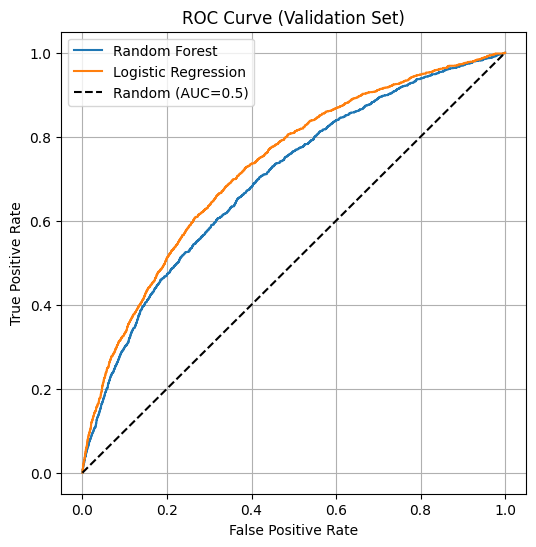

In [36]:
#Evaluation with metrics:

#Metric 1: ROC-AUC
rf_val_pred = rf_model.transform(val_data)
lr_val_pred = lr_model.transform(val_data)
auc_eval = BinaryClassificationEvaluator(
    labelCol=label_col,
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

print("RF AUC:", auc_eval.evaluate(rf_val_pred))
print("LR AUC:", auc_eval.evaluate(lr_val_pred))

# ---- Random Forest ----
rf_pd = rf_val_pred.select(
    col(label_col).alias("y"),
    vector_to_array("probability")[1].alias("p")
).sample(fraction=0.3, seed=42).toPandas()  # subsample for safety

rf_fpr, rf_tpr, _ = roc_curve(rf_pd["y"], rf_pd["p"])

# ---- Logistic Regression ----
lr_pd = lr_val_pred.select(
    col(label_col).alias("y"),
    vector_to_array("probability")[1].alias("p")
).sample(fraction=0.3, seed=42).toPandas()

lr_fpr, lr_tpr, _ = roc_curve(lr_pd["y"], lr_pd["p"])

# ---- Plot ----
plt.figure(figsize=(6, 6))
plt.plot(rf_fpr, rf_tpr, label="Random Forest")
plt.plot(lr_fpr, lr_tpr, label="Logistic Regression")
plt.plot([0, 1], [0, 1], "k--", label="Random (AUC=0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation Set)")
plt.legend()
plt.grid(True)
plt.show()

#Metric 2: PR-AUC
pr_eval = BinaryClassificationEvaluator(
    labelCol=label_col,
    rawPredictionCol="rawPrediction",
    metricName="areaUnderPR"
)

print("RF PR-AUC:", pr_eval.evaluate(rf_val_pred))
print("LR PR-AUC:", pr_eval.evaluate(lr_val_pred))

